# Reduced Order Modeling using Shallow ReLU Networks with Grassmann Layers

In this notebook, we provide sample code to reproduce results described in 
<a name="ref-1"/>[(Bollinger and Schaeffer, 2020)](#cite-bollinger2020reduced).

In [1]:
import time

import numpy as np

import torch
import torch.nn as nn

from pymanopt.manifolds import Grassmann
from pymanopt import Problem
from pymanopt.solvers import SteepestDescent

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

### Loading Data

The code provided in this notebook assumes data is stored in the following way:
- Data is stored as .npy files, with each data points stored in rows.
- There are 2 or 3 data files, with directories provided by user: 
    - input data, labeled throughout code as $y$
    - output data, labeled throughout code as $v$
    - (optional) derivative data, labeled throughout code as $dv$. (If no derivative information is available, just use None for the $dv$ directory and use either identity or random initialization for $U$.)
    
We have provided data files of this form in the "raw_data" folder. This provided data corresponds to the drag coefficient associated with the NACA0012 airfoil with respect to 18-shape parameters. If you would like to apply this model to a different data set, just make sure your data files conform to the structure described above and provide the appropriate data directories in lines 4-6 of the code cell below.

In [2]:
'''
Define input/output/derivative data directories below.
'''
y_dir = 'raw_data/y.npy'
v_dir = 'raw_data/v.npy'
dv_dir = 'raw_data/dv.npy'

Define the training and validation set size using the "train_num" and "val_num" variables defined below.

In [3]:
train_num = 50
val_num = 50

The code provided in this notebook will choose "train_num" and "val_num" randomly chosen data points (without replacement, to ensure the training set and validation set do not share data points) from the data files referenced above. If you wish to fix the randomness in choosing data points (e.g. if you would like to test different hyperparameters while keeping your data sets fixed) uncomment the line below.

In [4]:
np.random.seed(0) # toggle comment to fix the random choice of train and val data
torch.random.manual_seed(0) # toggle comment to fix random initializion of parameters within the Neural Network

### Setting Hyperparameters

Below is the collection of hyperparameters used for this model:
- init_type: how to initialize the active subspace $U$
    - 'acs' = use derivative information to find best approximation of $U$
    - 'id' = initialize with identity matrix
    - 'rn' = initialize with random matrix
- max_outIter: the number of outer iterations the model will perform
- acs_dim: active subspace dimension ($k$)
- hidden_dim: hidden layer dimension of the network
- lr: learning rate for ADAM optimizer in Neural Network Subproblem
- lr_decay: learning rate decay for ADAM optimizer in Neural Network Subproblem
- l2_reg_scale: $\ell_2$ regularization parameter ($\lambda$)
- batch_size: batch size used in Neural Network Subproblem
- num_epoch: number of inner iterations (epochs) used in the Neural Network Subproblem ($N_\theta$)
- numPrint_epoch: number of inner iterations (epochs) at which to save current loss values

In [5]:
init_type = 'acs' # ['acs','id','rn']
max_outIter = 5

acs_dim = 2
hidden_dim = 10

lr = 0.001
lr_decay = 0.9
l2_reg_scale = 1e-7

batch_size = 16
num_epoch = 5000
numPrint_epoch = 500

### Creating/Defining Model Structure

Load data, and define training/validation data subsets:

In [6]:
''' Load raw_data. '''
y = np.load(y_dir)
v = np.load(v_dir)
dv = np.load(dv_dir)

''' Choose data points from raw data. '''
tot_num = y.shape[0] # total number of data points to choose from
ind = list(range(tot_num)) # define indices to choose data points
np.random.shuffle(ind) # shuffle indices to choose data points at random

# choose training and validation indices from shuffled list ind
train_ind = ind[:train_num]; del ind[:train_num] # delete used indices
val_ind = ind[:val_num]; del ind[:val_num] # delete used indices
    
# choose training and validation data points defined by their respective indices
train_y = y[train_ind,:]; train_v = v[train_ind,:]; train_dv = dv[train_ind,:]
val_y = y[val_ind,:] ; val_v = v[val_ind,:]

''' Define input/output dimensions of data. '''
input_dim = train_y.shape[-1] # dimension of input data
output_dim = train_v.shape[-1] # dimension of output data

Initialize active subspace, $U$.

In [7]:
''' Initialize U0. '''
if init_type == 'id':
    U0 = np.eye(input_dim, acs_dim)
elif init_type == 'rn':
    U0 = np.linalg.qr(np.random.normal(size=(input_dim,acs_dim)))[0] # QR decomp, take Q for orthonomal random matrix
elif init_type == 'acs':
    U0, _, _ = np.linalg.svd(train_dv.transpose(), full_matrices=False)
    U0 = U0[:,:acs_dim]

Define the two layer ReLU network, $g$:

In [8]:
class MLP(nn.Module):
    '''
    Notation:
        h_0 = first layer of network
        h_last = last layer of network
        h_i (1 <= i <= last-1) can refer to the ith hidden layer
    '''
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.h_0 = nn.Linear(input_dim, hidden_dim) 
        self.h_last = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.ReLU()
        return
    def forward(self, x0, U):
        x0 = torch.matmul(x0, U)
        x1 = self.h_0(x0)
        x2 = self.sigmoid(x1)
        x3 = self.h_last(x2)
        return x3
    
''' Define network structure. '''
net = MLP(input_dim=acs_dim, hidden_dim=hidden_dim, output_dim=output_dim)
optimizer = torch.optim.Adam(net.parameters(), lr=lr,weight_decay=l2_reg_scale) 
criterion = nn.MSELoss(reduction='mean')

### Perform Alternating Minimization Process

**Below is a collection of functions to carry out the alternating minimization algorithm.**

*Neural Network Approximation Subproblem, Related Functions*

In [9]:
''' Neural Network Functions. '''

def print_epoch(epoch,num_epoch,loss_train,loss_val,overwrite):
    '''
    NOTES: Structure for nice printing of train/validation loss for given epoch.

    INPUT: 
        epoch = int; current epoch number
        num_epoch = int; total number of epochs that will be executed
        loss_train = float; error for training data
        loss_val = float; error for validation data
        overwrite = bool; choice to overwrite printed line

    OUTPUT:
        None
    '''
    assert (type(epoch) == int),'epoch must be int.'
    assert (type(num_epoch) == int),'num_epoch must be int.'
    assert (type(overwrite) == bool),'overwrite must be bool.'

    line = 'Epoch {}/{}'.format(epoch+1, num_epoch)
    line += ' | ' + 'Train Rel Loss: {:.8f}'.format(loss_train)
    line += ' | ' + 'Validation Rel Loss: {:.8f}'.format(loss_val)
    if overwrite:
        print(line, end='\r')
    else:
        print(line)

def train_nnwsub(train_y,train_v,val_y,val_v,U,net,criterion,optimizer,batch_size,num_epoch,numPrint_epoch,epoch_sto,train_loss_sto,val_loss_sto,denom):
    '''
    NOTES: Trains neural network composed with the linear function U, i.e. net(U(train_y))
            and checks against validation data, and saves network state_dict and optimizer state_dict. 
            All data has the following structure: axes
                - 0 = ith sample
                - -1 = ith dimension of data

    INPUT: 
        train_y = training data input
        train_v = training data output
        val_y = validation data input
        val_v = validation data output
        U = 2D array; U.shape[0] = dimension of input data, U.shape[1] = desired dimension of subspace
        net = network function
        criterion = loss function
        optimizer = optimization algorithm
        train_loss_sto = array/list to store loss values
        dir_name = string with name of directory to save results
        args = user input/parameters

    OUTPUT:
        None
    '''
    assert (len(U.shape) == 2),'U must be 2D array'

    start = time.time()

    # convert data to torch tensor
    train_y_tensor = torch.from_numpy(train_y).float()
    train_v_tensor = torch.from_numpy(train_v).float()
    val_y_tensor = torch.from_numpy(val_y).float()
    val_v_tensor = torch.from_numpy(val_v).float()

    U = torch.from_numpy(U).float()

    # create batches for training data
    train_dataset = torch.utils.data.TensorDataset(train_y_tensor, train_v_tensor)
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True)

    # run training
    current_step = 0
    for epoch in range(num_epoch):
        for i, (train_y_batch, train_v_batch) in enumerate(train_loader):  
            current_step += 1
            def closure():
                optimizer.zero_grad()
                loss = criterion(net(train_y_batch,U), train_v_batch)
                loss.backward()
                return loss
            optimizer.step(closure)

        if (epoch+1) % numPrint_epoch == 0:
            with torch.no_grad():
                loss_train = criterion(net(train_y_tensor,U), train_v_tensor)
                loss_val = criterion(net(val_y_tensor,U), val_v_tensor)
                epoch_sto.append(epoch_sto[-1]+numPrint_epoch) # store new epoch value
                train_loss_sto.append(np.sqrt(loss_train.numpy()/denom)) # store new loss value
                val_loss_sto.append(np.sqrt(loss_val.numpy()/denom)) # store new loss value
                print_epoch(epoch, num_epoch, train_loss_sto[-1], val_loss_sto[-1], overwrite=False) # print after print_epoch number of epochs
                    
    end = time.time()
    print('\nNetwork training running time: {}'.format(end-start))


*Subspace Approximation Subproblem, Related Functions*

In [10]:
''' Subspace code. '''
def sub_res(train_y,train_v,U,net,criterion):
    '''
    NOTES: Defines cost function w.r.t. U. 
            All data has the following structure: axes
                - 0 = ith sample
                - -1 = ith dimension of data

    INPUT: 
        train_y = training data input
        train_v = training data output
        U = 2D array; U.shape[0] = dimension of input data, U.shape[1] = desired dimension of subspace
        net = network function
        criterion = loss function

    OUTPUT:
        None
    '''
    assert (len(U.shape) == 2),'U must be 2D array'

    # convert data to torch tensor
    train_y = torch.from_numpy(train_y).float()
    train_v = torch.from_numpy(train_v).float()

    U = torch.from_numpy(U).float()

    with torch.no_grad():
        out = criterion(net(train_y,U),train_v)

    return out

def sub_dres(train_y,train_v,U,net,criterion):
    '''
    NOTES: Defines derivative of cost function w.r.t. U. 
            All data has the following structure: axes
                - 0 = ith sample
                - -1 = ith dimension of data

    INPUT: 
        train_y = training data input
        train_v = training data output
        U = 2D array; U.shape[0] = dimension of input data, U.shape[1] = desired dimension of subspace
        net = network function
        criterion = loss function

    OUTPUT:
        None
    '''
    assert (len(U.shape) == 2),'U must be 2D array'

    # convert data to torch tensor
    train_y = torch.from_numpy(train_y).float()
    train_v = torch.from_numpy(train_v).float()

    U = torch.from_numpy(U).float()

    U.requires_grad = True

    loss = criterion(net(train_y,U),train_v)
    loss.backward()

    return U.grad.numpy()

def train_sub(train_y,train_v,U0,net,criterion,denom):
    '''
    NOTES: Trains subspace U. 
            All data has the following structure: axes
                - 0 = ith sample
                - -1 = ith dimension of data

    INPUT: 
        train_y = training data input
        train_v = training data output
        U0 = 2D array; U0.shape[0] = dimension of input data, U0.shape[1] = desired dimension of subspace
        net = network function
        criterion = loss function

    OUTPUT:
        None
    '''
    assert (len(U0.shape) == 2),'U0 must be 2D array'

    # instantiate the Grassmann manifold  
    m, n = U0.shape
    manifold = Grassmann(m, n)

    # print loss before optimization (sanity check)
    print('\nLoss before Grassman Opt: {:.8f}'.format(np.sqrt(sub_res(train_y,train_v,U0,net,criterion)/denom)))

    # define cost and gradient functions
    cost = lambda U: sub_res(train_y, train_v, U, net, criterion)
    grad = lambda U: sub_dres(train_y, train_v, U, net, criterion)

    # instantiate optimization problem over Grassman manifold
    problem = Problem(manifold=manifold, cost=cost, egrad=grad, verbosity=0)
    solver = SteepestDescent(logverbosity=0)

    U = solver.solve(problem, x=U0) # update U

    # print loss after optimization
    loss_train = sub_res(train_y,train_v,U,net,criterion)
    print('Loss after Grassman Opt: {:.8f}'.format(np.sqrt(loss_train/denom)))

    return U

Begin alternating minimization process.

In [11]:
ite = 0 # initialize outer iteration counter
U = np.copy(U0) # to not overwrite U0, if wanted for reference later

denom = np.linalg.norm(v,ord='fro')**2/v.shape[0] # denominator for relative error
epoch_sto = [0] # initialize list to store epoch values where loss is calculate/stored
with torch.no_grad():
    train_loss_sto = [np.sqrt(criterion(net(torch.from_numpy(train_y).float(),torch.from_numpy(U).float()), torch.from_numpy(train_v).float())/denom)] # initialize list to store training loss
    val_loss_sto = [np.sqrt(criterion(net(torch.from_numpy(val_y).float(),torch.from_numpy(U).float()), torch.from_numpy(val_v).float())/denom)] # initialize list to store validation loss

''' Begin Alternating Minimization Process. '''
while ite < max_outIter:
    ''' Update iteration count. '''
    ite += 1
    print('\nAlternating minimization iteration count: {}\n'.format(ite))

    ''' Train network. '''
    train_nnwsub(train_y,train_v,val_y,val_v,U,
                 net,criterion,optimizer,batch_size,num_epoch,numPrint_epoch,
                 epoch_sto,train_loss_sto,val_loss_sto,denom)    
    optimizer = torch.optim.Adam(
                    net.parameters(), 
                    lr=(lr_decay**(ite))*lr,
                    weight_decay=l2_reg_scale
                    ) 
    
    ''' Train subspace. '''
    U = train_sub(train_y,train_v,U,net,criterion,denom)


Alternating minimization iteration count: 1

Epoch 500/5000 | Train Rel Loss: 0.23187724 | Validation Rel Loss: 0.21485305
Epoch 1000/5000 | Train Rel Loss: 0.16013407 | Validation Rel Loss: 0.17038971
Epoch 1500/5000 | Train Rel Loss: 0.16228851 | Validation Rel Loss: 0.17232800
Epoch 2000/5000 | Train Rel Loss: 0.17117875 | Validation Rel Loss: 0.17957860
Epoch 2500/5000 | Train Rel Loss: 0.15730448 | Validation Rel Loss: 0.17055952
Epoch 3000/5000 | Train Rel Loss: 0.15659562 | Validation Rel Loss: 0.16910946
Epoch 3500/5000 | Train Rel Loss: 0.17648117 | Validation Rel Loss: 0.18543608
Epoch 4000/5000 | Train Rel Loss: 0.16874821 | Validation Rel Loss: 0.17803754
Epoch 4500/5000 | Train Rel Loss: 0.15597356 | Validation Rel Loss: 0.16841686
Epoch 5000/5000 | Train Rel Loss: 0.18850379 | Validation Rel Loss: 0.20230684

Network training running time: 11.31084156036377

Loss before Grassman Opt: 0.18850379
Loss after Grassman Opt: 0.15788774

Alternating minimization iteration count

### Plot Results

Plot relative error, defined below.
$$
\text{RelError}_{p,n}  = \left( \frac{\frac{1}{| X_{Validation} |} \sum_{x\in X_{Validation}} \| f(x)-g_{\theta^{p,n}}((U^{p,0})^T x)\|_2^2}{\frac{1}{|X|} \sum_{x\in X} \| f(x) \|_2^2} \right)^{\frac{1}{2}} 
.
$$
(Where, as defined in <a name="ref-1"/>[(Bollinger and Schaeffer, 2020)](#cite-bollinger2020reduced), $X_{Validation}$ is the validation set, and $X$ is the entire avaliable data set.)

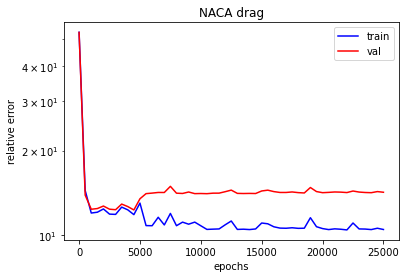

In [12]:
''' Calulate relative error based on network MSE Loss. '''
train_rel_error = np.sqrt(train_loss_sto/denom)
val_rel_error = np.sqrt(val_loss_sto/denom)

''' Plot results. '''
input_label = 'epochs'
output_label = 'relative error'
title = 'NACA drag'

plt.close()
fig = plt.figure()

plt.plot(epoch_sto,train_rel_error,'b',label='train')
plt.plot(epoch_sto,val_rel_error,'r',label='val')

plt.legend(loc='upper right')
plt.yscale('log')
plt.xlabel(input_label)
plt.ylabel(output_label)
plt.title(title)
plt.show()
plt.close()

<!--bibtex

@misc{bollinger2020reduced,
      title={Reduced Order Modeling using Shallow ReLU Networks with Grassmann Layers}, 
      author={Kayla Bollinger and Hayden Schaeffer},
      year={2020},
      eprint={2012.09940},
      archivePrefix={arXiv},
      primaryClass={cs.LG}
}

-->

# References

<a name="cite-bollinger2020reduced"/><sup>[^](#ref-1) </sup>Kayla Bollinger and Hayden Schaeffer. 2020. _Reduced Order Modeling using Shallow ReLU Networks with Grassmann Layers_.

